In [106]:
import pandas as pd
import glob
import os
from autorank import autorank, plot_stats, create_report
from itertools import product
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ['DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Palatino', 'Charter', 'serif'],
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.title_fontsize": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "lines.linewidth": 2,
    "lines.markersize": 6,
    "legend.frameon": False,
    "figure.figsize": (9, 3)  # standard size for subplots
})
COLORS = ['#4c90b8', '#2ac3c1', '#f5b811', '#de653e', '#ff912a']
color_dict = {
    'BaselineAll': 'black',
    'BaselineNone': 'gray',
    'DisagreementSampling(DT)': COLORS[3],
    'DisagreementSampling(DS)': COLORS[4],
    'RandomSampling': COLORS[0],
    # add other sampling methods as needed
}
style_map = {
    'BaselineAll':    (color_dict['BaselineAll'], 'o'),
    'BaselineNone':  (color_dict['BaselineNone'], 's'),
    'DisagreementSampling(DT)':    (color_dict['DisagreementSampling(DT)'], 'o'),
    'DisagreementSampling(DS)':  (color_dict['DisagreementSampling(DS)'], '*'),
    'RandomSampling':    (color_dict['RandomSampling'], 'D'),
}

# 0. Load Result Data

In [3]:
# downstream performance and time results
df_all = pd.read_csv('results/tabnet.csv')

df_all['sampling_method'] = df_all['sampling_method'].replace({
    'ConsensusSampling(DT)': 'DisagreementSampling(DT)',
    'ConsensusSampling(DS)': 'DisagreementSampling(DS)'
})

In [4]:
# invert sign for running times
df_all.loc[df_all['metric'] == 'total_time', 'value'] *= -1
df_all.loc[df_all['metric'] == 'sampling_time', 'value'] *= -1
df_all.loc[df_all['metric'] == 'model_time', 'value'] *= -1

# cleaner presentation of brackets
df_clean = df_all.copy()
bracket_cleaner = {40: '0-40', 60: '20-60', 80: '40-80', 100: '60-100', 0: 'all', np.nan: 'all'}
df_clean['bracket'] = df_clean['bracket_max'].map(bracket_cleaner)
df_clean = df_clean.drop(['bracket_min', 'bracket_max', 'mean', 'sampling_strategy', 'n_selected'], axis=1)

# joining corresponding baselines
baseline_none = df_clean[df_clean['sampling_method'] == 'BaselineNone'].drop(['bracket', 'sampling_method', 'n_sample'], axis=1).rename(columns={'value': 'baseline_none'})
baseline_all = df_clean[df_clean['sampling_method'] == 'BaselineAll'].drop(['bracket', 'sampling_method', 'n_sample'], axis=1).rename(columns={'value': 'baseline_all'})
df_clean = df_clean[~df_clean['sampling_method'].isin(['BaselineNone', 'BaselineAll'])]
join_keys = ['dataset', 'n_labeled', 'metric', 'seed']
df_clean = pd.merge(df_clean, baseline_none, on=join_keys, how='left')
df_clean = pd.merge(df_clean, baseline_all, on=join_keys, how='left')
df_clean_avg = df_clean.groupby(['dataset', 'n_labeled', 'n_sample', 'sampling_method', 'metric', 'bracket'])[['value', 'baseline_none', 'baseline_all']].mean().reset_index()

# finding the best bracket by AUPRC
df_agg = df_clean_avg[df_clean_avg['metric'] == 'auprc_macro']
idx_max_value = df_agg.groupby(['dataset', 'n_labeled', 'sampling_method', 'n_sample'])['value'].idxmax()
df_best_bracket = df_agg.loc[idx_max_value]
idx_max_value = df_agg.groupby(['dataset', 'n_labeled', 'sampling_method'])['value'].idxmax()
df_best_nsample_bracket = df_agg.loc[idx_max_value]

# 1. Time Compared to Baselines

How much faster than the baselines is sampling?

In [65]:
# Step 1: Filter to only AUPRC and total_time
df_eff = df_clean_avg[df_clean_avg['metric'].isin(['auprc_macro', 'total_time'])].copy()
# df_eff = df_eff[df_eff['sampling_method'] != 'DisagreementSampling(DS)']  ### <----- or remove DT

# Step 2: Pivot to wide format with value + baselines
df_eff = df_eff.pivot_table(
    index=['dataset', 'n_labeled', 'n_sample', 'sampling_method', 'bracket'],
    columns='metric',
    values=['value', 'baseline_all', 'baseline_none']
).reset_index()

# Flatten the multi-index columns
df_eff.columns = ['_'.join(col).strip('_') if isinstance(col, tuple) else col for col in df_eff.columns]

# Step 3: Get best row per group (highest value_auprc_macro)
df_best = df_eff.sort_values('value_auprc_macro', ascending=False).groupby(
    ['dataset', 'n_labeled', 'n_sample', 'sampling_method'], as_index=False
).first()

In [66]:
df_best['time_ratio_to_baseline_all'] = df_best['value_total_time'] / df_best['baseline_all_total_time']

In [67]:
df_time = df_best.groupby(['n_sample','sampling_method'])['time_ratio_to_baseline_all'].mean()
df_time

n_sample  sampling_method         
100       DisagreementSampling(DS)    0.198008
          DisagreementSampling(DT)    0.199271
          RandomSampling              0.205311
250       DisagreementSampling(DS)    0.218954
          DisagreementSampling(DT)    0.218949
          RandomSampling              0.215452
500       DisagreementSampling(DS)    0.255799
          DisagreementSampling(DT)    0.255688
          RandomSampling              0.252686
750       DisagreementSampling(DS)    0.295843
          DisagreementSampling(DT)    0.296200
          RandomSampling              0.293007
1000      DisagreementSampling(DS)    0.329250
          DisagreementSampling(DT)    0.329841
          RandomSampling              0.331858
Name: time_ratio_to_baseline_all, dtype: float64

In [68]:
print(df_time.to_latex())

\begin{tabular}{llr}
\toprule
 &  & time_ratio_to_baseline_all \\
n_sample & sampling_method &  \\
\midrule
\multirow[t]{3}{*}{100} & DisagreementSampling(DS) & 0.198008 \\
 & DisagreementSampling(DT) & 0.199271 \\
 & RandomSampling & 0.205311 \\
\cline{1-3}
\multirow[t]{3}{*}{250} & DisagreementSampling(DS) & 0.218954 \\
 & DisagreementSampling(DT) & 0.218949 \\
 & RandomSampling & 0.215452 \\
\cline{1-3}
\multirow[t]{3}{*}{500} & DisagreementSampling(DS) & 0.255799 \\
 & DisagreementSampling(DT) & 0.255688 \\
 & RandomSampling & 0.252686 \\
\cline{1-3}
\multirow[t]{3}{*}{750} & DisagreementSampling(DS) & 0.295843 \\
 & DisagreementSampling(DT) & 0.296200 \\
 & RandomSampling & 0.293007 \\
\cline{1-3}
\multirow[t]{3}{*}{1000} & DisagreementSampling(DS) & 0.329250 \\
 & DisagreementSampling(DT) & 0.329841 \\
 & RandomSampling & 0.331858 \\
\cline{1-3}
\bottomrule
\end{tabular}



# 2. Time vs. AUPRC

Close look at the time/performance trade-off

In [99]:
df_plot = df_all.copy()
bracket_cleaner = {40: '0-40', 60: '20-60', 80: '40-80', 100: '60-100', 0: 'all', np.nan: 'all'}
df_plot['bracket'] = df_plot['bracket_max'].map(bracket_cleaner)
df_plot = df_plot.drop(['bracket_min', 'bracket_max', 'mean', 'sampling_strategy', 'n_selected'], axis=1)
df_plot = df_plot[df_plot['metric'].isin(['auprc_macro', 'total_time'])]
df_plot = df_plot[df_plot['n_labeled'].isin([100, 500, 1000])]


In [100]:
df_wide = df_plot.pivot_table(
    index=['dataset', 'seed', 'n_labeled', 'n_sample', 'sampling_method', 'bracket'],
    columns='metric',
    values='value'
).reset_index()
df_wide['log_total_time'] = np.log(-df_wide['total_time'])

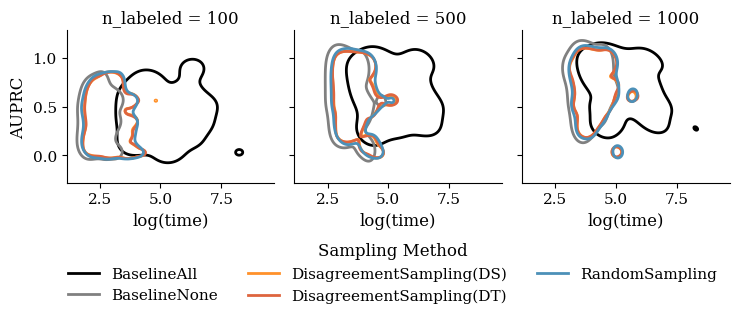

In [111]:
g = sns.FacetGrid(
    df_wide,
    col='n_labeled',
    hue='sampling_method',
    palette=color_dict,
    height=2.5,
    aspect=1,
    sharex=True,
    sharey=True,
)

g.map_dataframe(
    sns.kdeplot,
    x='log_total_time',
    y='auprc_macro',
    fill=False,
    # alpha=0.2,
    linewidth=2,
    thresh=0.1,
    levels=2
)

g.set_axis_labels("log(time)", "AUPRC")
g.set_titles("n_labeled = {col_name}")

# Create one dummy line per sampling method for the legend
handles = [
    mlines.Line2D([], [], color=color_dict[method], label=method, linewidth=2)
    for method in df_wide['sampling_method'].unique()
]

# Add manual legend below the grid
g.fig.legend(
    handles=handles,
    title="Sampling Method",
    loc="lower center",
    bbox_to_anchor=(0.53, -0.29),
    ncol=3,
    frameon=False
)

plt.subplots_adjust(bottom=0.18)
plt.tight_layout()
plt.savefig('plots/3_2_time_vs_auprc.pdf', bbox_inches='tight')
plt.show()


# 3. Time vs. n_sample

In [69]:
join_on = ['dataset', 'n_labeled', 'n_sample']
df_best_daDT = df_best[df_best['sampling_method'] == 'DisagreementSampling(DT)']
df_best_daDS = df_best[df_best['sampling_method'] == 'DisagreementSampling(DS)'][join_on + ['value_total_time']]
df_best_ra = df_best[df_best['sampling_method'] == 'RandomSampling'][join_on + ['value_total_time']]

In [70]:
df_plot = pd.merge(df_best_daDT, df_best_daDS, on=join_on, how='left')
df_plot = pd.merge(df_plot, df_best_ra, on=join_on, how='left')

In [71]:
fractions = df_best['n_sample'].unique()
competitors= ['baseline_all_total_time', 'baseline_none_total_time', 'value_total_time_x', 
              'value_total_time_y', 'value_total_time']
ranks_per_fraction = []
cds_per_fraction = []

for n_sample in fractions: 
    result = autorank(df_plot[df_plot['n_sample']==n_sample][competitors])

    # Average ranks (dict)
    avg_ranks = result.rankdf['meanrank']

    # CD value from Nemenyi post-hoc
    cd = result.cd

    # Sort ranks by method order
    ordered_ranks = [avg_ranks[method] for method in competitors]

    ranks_per_fraction.append(ordered_ranks)
    cds_per_fraction.append(cd)

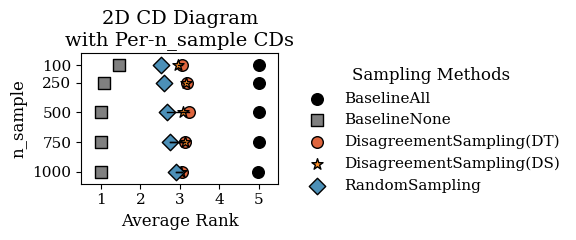

In [80]:
fig, ax = plt.subplots(figsize=(6, 2.5))

# Plot each method's average rank across fractions
for i, method in enumerate(['BaselineAll', 'BaselineNone', 'DisagreementSampling(DT)',
                            'DisagreementSampling(DS)', 'RandomSampling']):
    color, marker = style_map[method]
    ax.scatter(np.array(ranks_per_fraction)[:, i], fractions, color=color, 
               marker=marker, label=method, s=70, edgecolor='k')

# Add CD lines (Nemenyi non-significant comparisons) per row
for i, (frac, cd) in enumerate(zip(fractions, cds_per_fraction)):
    row = ranks_per_fraction[i]
    for j in range(len(competitors)):
        for k in range(j + 1, len(competitors)):
            if abs(row[j] - row[k]) <= cd:
                x1, x2 = row[j], row[k]
                ax.plot([x1, x2], [frac, frac], color='black', linewidth=1)

# Axis formatting
ax.set_ylim(0, 1100)
ax.set_xlim(0.5, len(competitors) + 0.5)
ax.set_yticks(fractions)
ax.set_xlabel("Average Rank")
ax.set_ylabel("n_sample")
ax.invert_yaxis()  # Optional: puts 1.0 on bottom
ax.set_title("2D CD Diagram\nwith Per-n_sample CDs")

# Add rank numbers at the top
ax.set_xticks(np.arange(1, len(competitors) + 1))
ax.set_xticklabels(np.arange(1, len(competitors) + 1))

# Legend
ax.legend(title="Sampling Methods", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('plots/3_3_time_vs_nsample.pdf', bbox_inches='tight')
plt.show()